# Extracting Value from Customer Complaints

Let's import some packages and implement some functions

In [247]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

def dateLookup(s):
    """
    Memoization solution for faster date_time parsing
    source: https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [248]:
c = pd.read_csv('Consumer_Complaints.csv')

#Take subset where complaint text is available
c = c[c['Consumer consent provided?'] == 'Consent provided']

#Convert yes/no strings to bool
for col in ['Consumer disputed?','Timely response?']:
    c[col] = (c[col] == 'Yes')
    
#Convert datetimes    
for col in ['Date received', 'Date sent to company']:
    c[col] = dateLookup(c[col])
    
#All complaints in our subset are submitted via web and have consent provided.
c = c.drop(['Consumer consent provided?','Submitted via'],axis='columns')

#Convert all others, convert yes/no bools to int64
dataTypes = {
    'Product':'category',
    'Sub-product':'category',
    'Issue':'category',
    'Sub-issue':'category',
    'Consumer complaint narrative':str,
    'Company public response':str,
    'Company':'category',
    'State':'category',
    'ZIP code':str,
    'Tags':str,
    'Company response to consumer':'category',
    'Timely response?':'int64',
    'Consumer disputed?':'int64',
    'Complaint ID':'int64'
}

c = c.astype(dataTypes)

columnNames = {
    'Date received':'date_received',
    'Product':'product',
    'Sub-product':'sub_product',
    'Issue':'issue',
    'Sub-issue':'sub_issue',
    'Consumer complaint narrative':'text',
    'Company public response':'pub_reply',
    'Company':'company',
    'State':'state',
    'ZIP code':'zip_code',
    'Tags':'tags',
    'Date sent to company':'date_sent',
    'Company response to consumer':'cust_reply',
    'Timely response?':'timely_reply',
    'Consumer disputed?':'int64',
    'Complaint ID':'int64'
}

c = c.rename(columns = columnNames)

#There are a few missing state entries, and not every complaint has a sub-product or sub-issue.

## Complaint Volume by State and Time

What's the average number of complaint per year for each state? Complaints per capita?
Get population data for 2015-2017 and update to reflect the average complaints per capita if interesting.

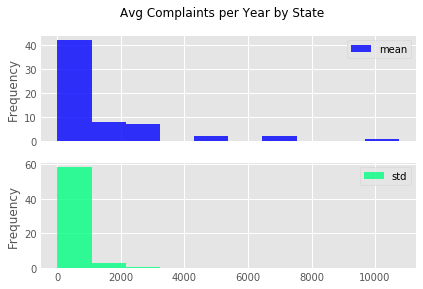

Outlier states: 
date_sent          mean          std     zmean      zstd
state                                                   
CA         10756.666667  2118.277655  4.918663  3.758876
FL          7168.666667  1839.636619  3.062137  3.179581
GA          4362.000000  1592.655016  1.609894  2.666106
IL          3030.333333   805.868613  0.920855  1.030377
NY          4357.333333   999.205462  1.607479  1.432325
TX          7124.000000  2172.453145  3.039026  3.871506

The number of complaints is generally increasing substantially.


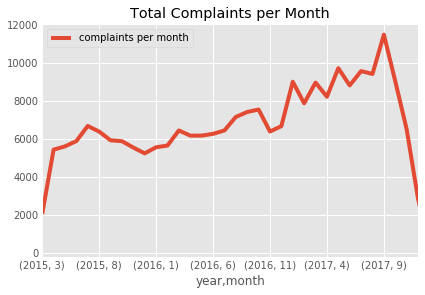

The ending drop off is odd. It seems likely that some data from november and december have not been added.
It also appears that data collection may have been scarce at the beginning of the data set.
2017 Monthly Complaints: 


,complaints per month
month,
1,8988
2,7855
3,8944
4,8202
5,9699
6,8797
7,9548
8,9398
9,11467


In [249]:
fullyears = c['date_sent'] < '2018'

piv = c[fullyears].pivot_table(index=['state'],columns=c['date_sent'].dt.year,values='product'
                               ,aggfunc='count').fillna(0)

piv['mean'] = piv.mean(axis=1)
piv['std'] = piv.std(axis=1)
piv['zmean'] = stats.zscore(piv['mean'])
piv['zstd'] = stats.zscore(piv['std'])

piv.plot(kind='hist',y=['mean','std'],alpha=0.8,subplots=True,cmap='winter',title='Avg Complaints per Year by State')
plt.show()

#display outliers
print("Outlier states: ")
print(piv[['mean','std','zmean','zstd']][(np.abs(piv['zmean']) > 1.0) | (np.abs(piv['zstd']) > 1.0)])

piv2 = c.pivot_table(index = [c['date_sent'].dt.year, c['date_sent'].dt.month]
                                         ,values='product',aggfunc='count')
piv2.index.names = ['year','month']
piv2.columns = ['complaints per month']

print()
print("The number of complaints is generally increasing substantially.")
piv2.plot(kind='line',title = 'Total Complaints per Month', xlim=[0,33])
plt.show()
print("The ending drop off is odd. It seems likely that some data from november and december have not been added.")
print("It also appears that data collection may have been scarce at the beginning of the data set.")
print("2017 Monthly Complaints: ")
piv2.loc[(2017),:]



## Class imbalances

We'd like to predict for the product and the issue labels given the text. Here are the class imbalances.

Create a collection of issues that are relevant (have counts of > 0) for each product.
Could be a dict.
Show topic label balance for each product.

Perhaps:
* Try bank account/service first.
* Try credit card second, where classes are less balanced.

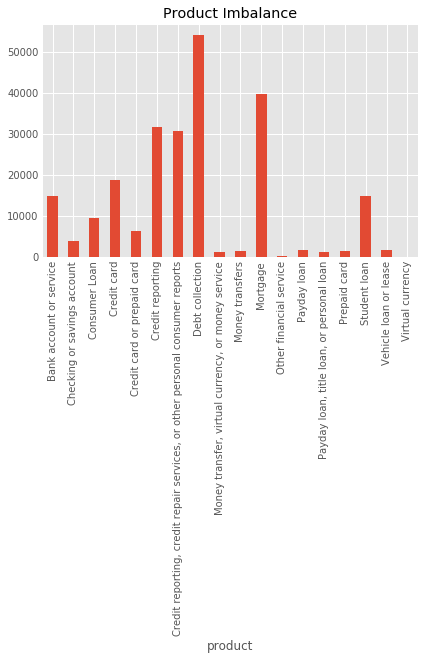

In [261]:
product_classes = c.groupby(['product'])['text'].count()
product_classes.plot(kind='bar',title='Product Imbalance')
plt.show()
    

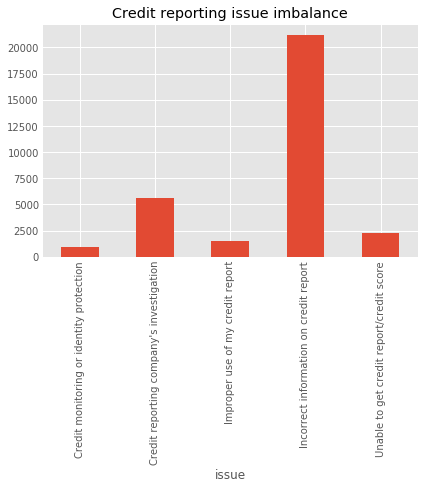

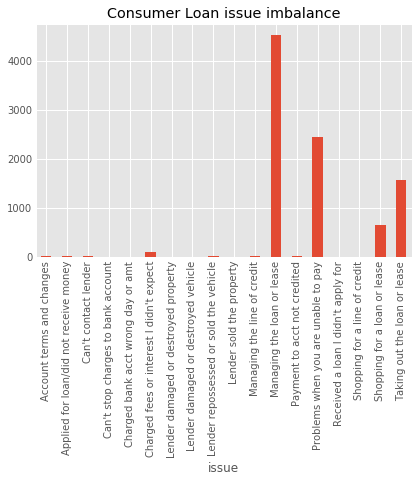

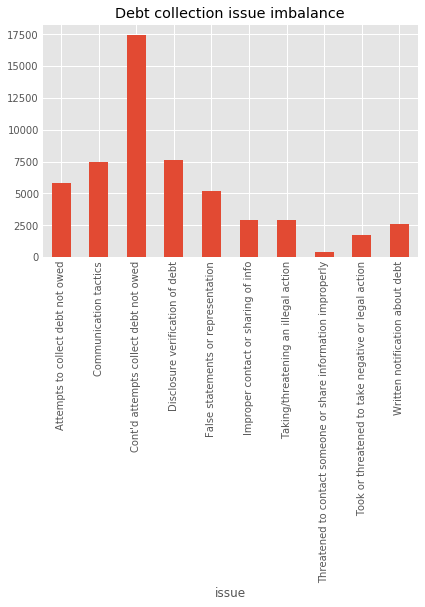

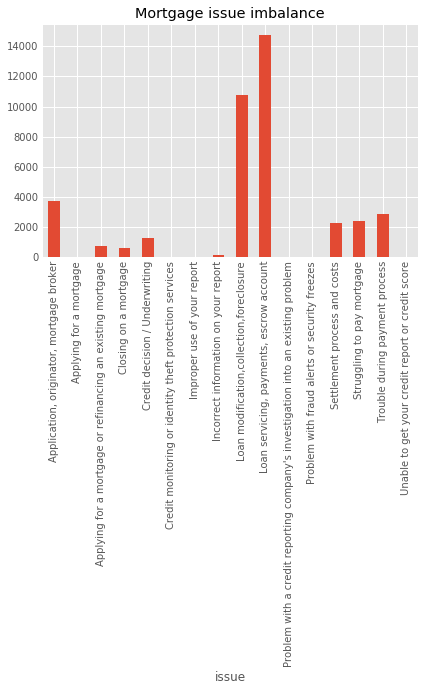

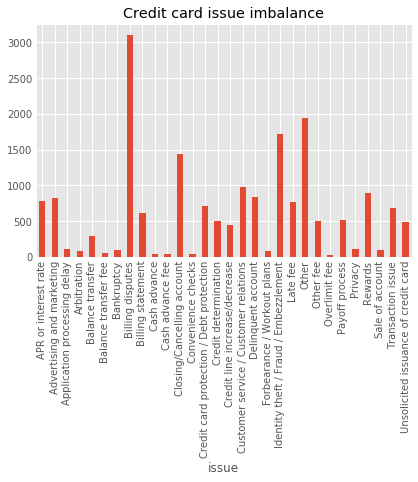

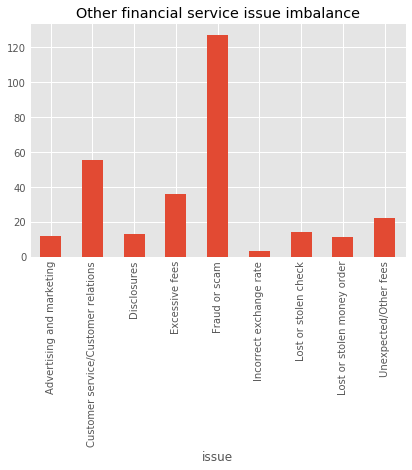

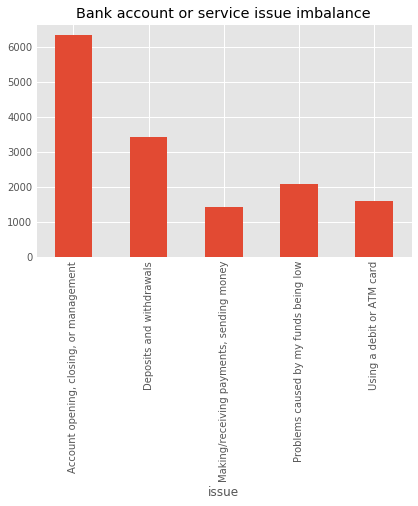

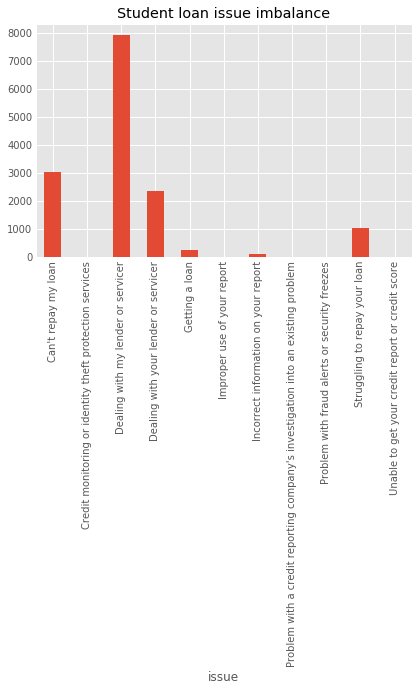

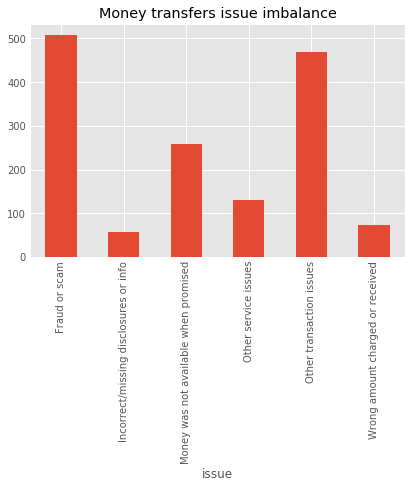

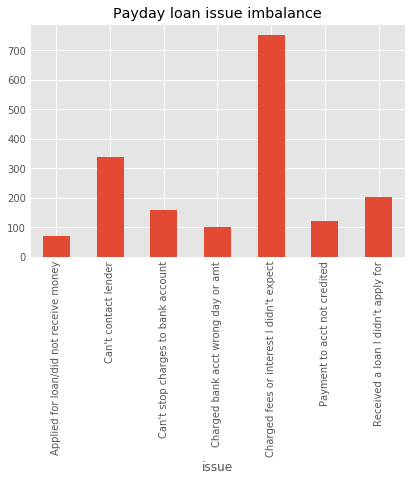

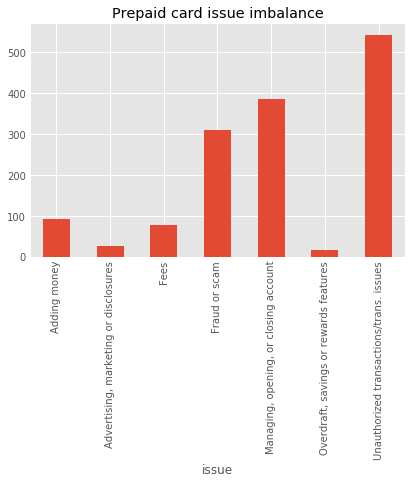

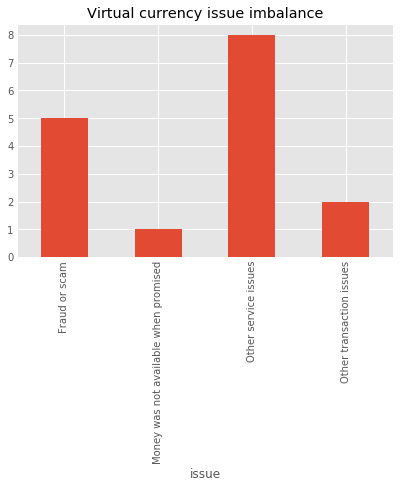

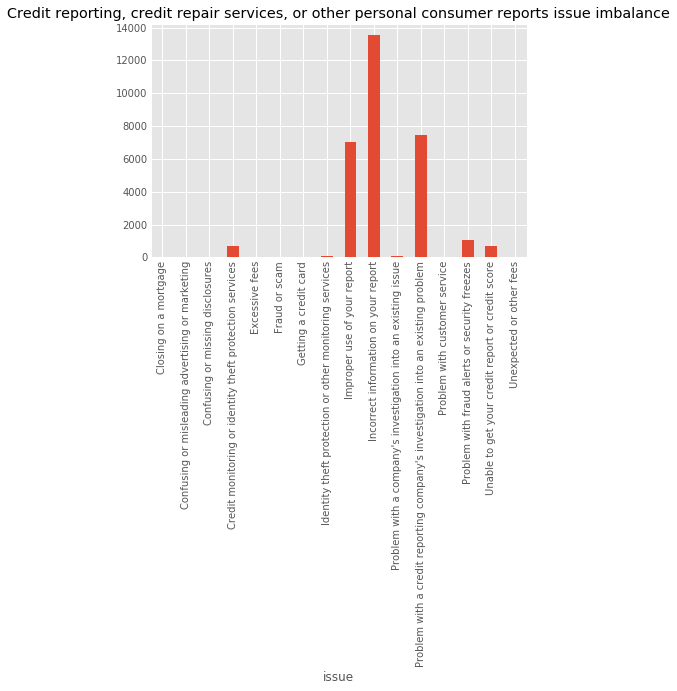

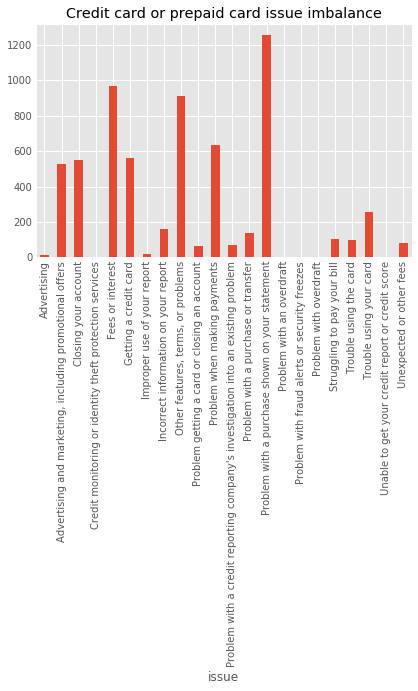

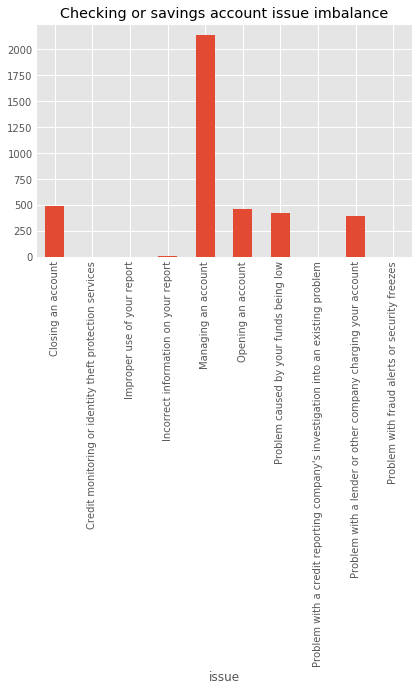

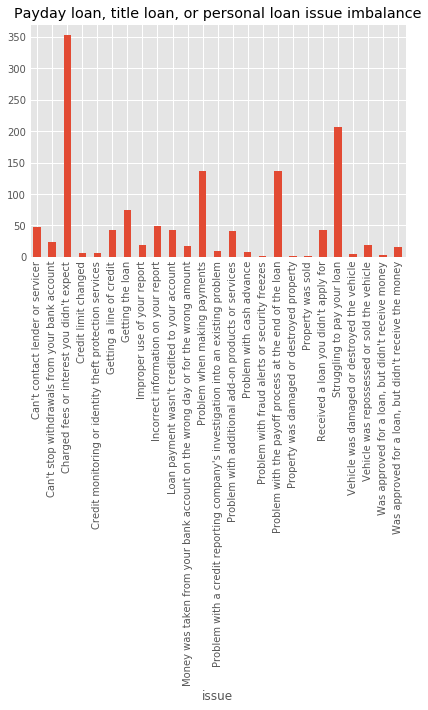

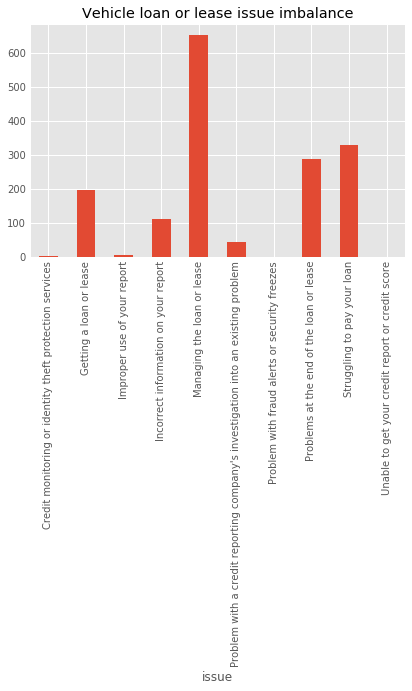

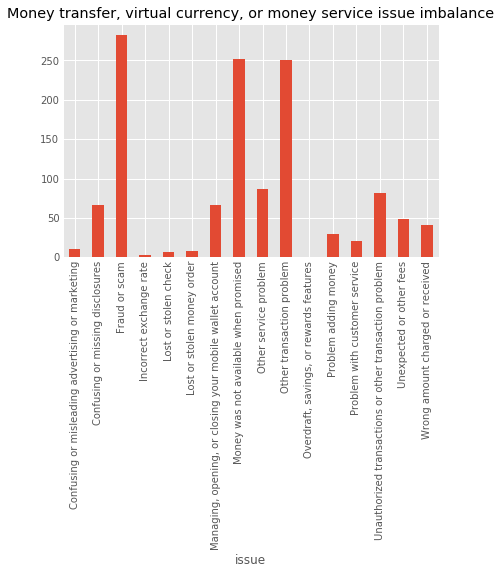

In [262]:
p_issue_class = c.groupby(['product','issue'])['text'].count()
for p in c['product'].unique():
    p_issue_class[p].plot(kind='bar',title = p + ' issue imbalance')
    plt.show()
    